<a href="https://colab.research.google.com/github/tigju/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [1]:
# TODO - your code!
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-02-01 17:23:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.1s    

2020-02-01 17:23:35 (130 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [0]:
import pandas as pd

In [0]:
column_headers = ['party','handicapped-infants','water-project', 'budget','physician-fee-freeze', 'el-salvador-aid',
                  'religious-groups','anti-satellite-ban', 'aid-to-contras','mx-missile','immigration',
                  'synfuels', 'education', 'right-to-sue','crime','duty-free', 'south-africa']
voting_records = pd.read_csv('house-votes-84.data', header=None, names=column_headers, na_values='?')

In [0]:
voting_records = voting_records.replace({'y': 1, 'n': 0})

In [5]:
voting_records.shape

(435, 17)

In [6]:
voting_records.isnull().sum()

party                     0
handicapped-infants      12
water-project            48
budget                   11
physician-fee-freeze     11
el-salvador-aid          15
religious-groups         11
anti-satellite-ban       14
aid-to-contras           15
mx-missile               22
immigration               7
synfuels                 21
education                31
right-to-sue             25
crime                    17
duty-free                28
south-africa            104
dtype: int64

In [46]:
dem = voting_records[voting_records['party'] == 'democrat']
dem

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,democrat,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN
426,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
428,democrat,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
429,democrat,1.0,0.0,1.0,0.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,1.0,1.0


In [47]:
rep = voting_records[voting_records['party'] == 'republican']
rep

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,republican,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
430,republican,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
432,republican,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
433,republican,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0


# Look into one single bill 'Budget' for democrat voters

1) Null hypothesis that the votes y/n are even among democrats

2) Alternative hypothesis that the votes are differ.

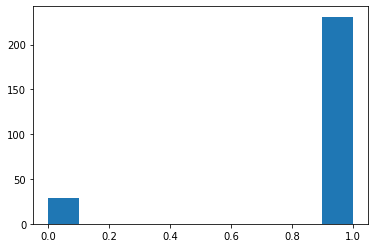

In [64]:
dem_budget_nona = dem['budget'].dropna()
plt.hist(dem_budget_nona);

In [65]:
dem_budget_nona.mean()

0.8884615384615384

In [0]:
import scipy.stats as stats
import numpy as np

In [0]:
def confidence_interval(data, confidence=0.95):
    """
    Calculate a confidence interval around a sample mean for given data.
    Using t-distribution and two-tailed test, default 95% confidence. 

    Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval

    Returns:
    tuple of (mean, lower bound, upper bound)
    """
    mean = np.mean(data)
    data = np.array(data)
    n = len(data)
    stderr = np.std(data)/np.sqrt(n)
    moe = stderr * stats.t.ppf((1 + confidence) / 2.0, n) # just looking up the corresponding t-stat.
    return (mean, mean - moe, mean + moe)

In [76]:
dem_budget_ci = confidence_interval(dem_budget_nona)
dem_budget_ci

(0.8884615384615384, 0.8500183539155728, 0.926904723007504)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
dem_budget_nona.mean()

0.8884615384615384

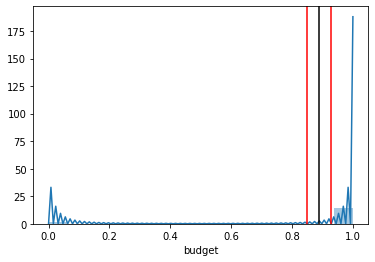

In [82]:
sns.distplot(dem_budget_nona)
CI = dem_budget_ci
plt.axvline(x=CI[1], color='red')
plt.axvline(x=CI[2], color='red')
plt.axvline(x=CI[0], color='k');

In [0]:
from scipy.stats import ttest_1samp, t


In [188]:
# using scipy built-in function t.interval for Confidence Interval
# Sample Size
n = len(dem_budget_nona)
# Degrees of Freedom
dof = n-1
# The Mean of Means:
mean = np.mean(dem_budget_nona)
# Sample Standard Deviation
sample_std = np.std(dem_budget_nona, ddof=1)
# Standard Error
std_err = sample_std/np.sqrt(n)

CI = t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.8499435153340718, 0.9269795615890051)


In [92]:
statistics_budget, pvalue_budget = ttest_1samp(dem_budget_nona, 0.5)
print(statistics_budget, pvalue_budget)

19.859406568628835 5.759315046608634e-54


Conclusion: I would only see that the votes are even 5% of the time for the Budget Bill among democrats, so I reject my null hypothesis.*italicized text*

# Look up the water-project bill for both parties


In [190]:
dem_mean = dem['water-project'].mean()
dem_mean

0.45161290322580644

In [191]:
rep_mean = rep['water-project'].mean()
rep_mean

0.4722222222222222

In [196]:
means_array = pd.array([dem_mean, rep_mean])
means_array

<PandasArray>
[0.45161290322580644, 0.4722222222222222]
Length: 2, dtype: float64

In [198]:
# Using scipy t.interval
# number of means
n = len(means_array)
n

2

In [200]:
# degrees of freedom
dof = n-1
dof

1

In [202]:
# the mean of means
mean_of_means = means_array.mean()
mean_of_means

0.4619175627240143

# Observation on Republicans voted Yes or No in general for every bill

1) Null hypothesis that they voted evenly 

2) Alternative hypothesis that they voted differently.

In [96]:
rep = rep.dropna()
rep

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
28,republican,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
30,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
33,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
35,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,republican,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
416,republican,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
420,republican,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
427,republican,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [174]:
rep_means = rep[1:].mean().values
rep_means

array([0.21495327, 0.46728972, 0.1588785 , 0.99065421, 0.95327103,
       0.86915888, 0.27102804, 0.14953271, 0.14018692, 0.57943925,
       0.1588785 , 0.85046729, 0.8411215 , 0.98130841, 0.11214953,
       0.6635514 ])

In [182]:
CI = confidence_interval(rep_means)
CI

(0.5251168224299065, 0.3450765400098871, 0.705157104849926)

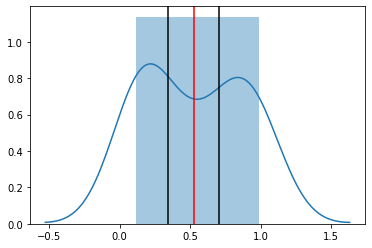

In [179]:
sns.distplot(rep_means)
plt.axvline(x=CI[1], color='k')
plt.axvline(x=CI[2], color='k')
plt.axvline(x=CI[0], color='r');

In [181]:
# Using t.interval method
# Sample Size
n = len(rep_means)
# Degrees of Freedom
dof = n-1
# The Mean of Means:
mean = np.mean(rep_means)
# Sample Standard Deviation
sample_std = np.std(rep_means, ddof=1)
# Standard Error
std_err = sample_std/np.sqrt(n)

CI = t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.33815942938429877, 0.7120742154755143)


In [186]:
# pick a value for my null hypothesis and check the p-value
ttest_1samp(rep_means, .5)

Ttest_1sampResult(statistic=0.2863499478785454, pvalue=0.7785271500056743)

I would see that the votes are even 95% of the time for all bills in general that republicans voted. A null hypothesis that's just inside of our confidence interval == fail to reject, therefore I fail to reject Null Hypothesis that Republicans voted on average equally for the bills in general. 

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)